# Time Series Mini Project

In [199]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

# set plt and seaborn defaults
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['axes.titlesize'] = 15

sns.set_style('darkgrid')

# to evaluated performance using rmse
from sklearn.metrics import mean_squared_error
from math import sqrt 

# for tsa seasonal decomp
import statsmodels.api as sm

# holt's linear trend model. 
from statsmodels.tsa.api import Holt

#custom modules

import prepare as p

In [3]:
state_df = pd.read_csv('GlobalLandTemperaturesByState.csv')

In [18]:
# pick all data from the state of texas
df1 = state_df[state_df.State == 'Texas']

In [75]:
df1.shape

(2325, 5)

In [19]:
df1.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,State,Country
549727,1820-01-01,4.489,3.369,Texas,United States
549728,1820-02-01,9.081,2.873,Texas,United States
549729,1820-03-01,12.657,2.423,Texas,United States
549730,1820-04-01,19.215,2.501,Texas,United States
549731,1820-05-01,22.577,2.495,Texas,United States


In [20]:
df1.info()
# Doesn't seem like there are any Nulls

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2325 entries, 549727 to 552051
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   dt                             2325 non-null   object 
 1   AverageTemperature             2325 non-null   float64
 2   AverageTemperatureUncertainty  2325 non-null   float64
 3   State                          2325 non-null   object 
 4   Country                        2325 non-null   object 
dtypes: float64(2), object(3)
memory usage: 109.0+ KB


## Plan
 - Convert dt to datetime and index (might have a function for that in prepare.py)
 - AverageTemperature will be target
 - Looking Average temperatures for all of Texas
 - Seems like dates are an average temperature per month

### Explore
- Look for NaNs (doesn't seem to be any from .info above)
- Seasonal Decomp Plot
- Lag plot
- Figure out how to split Probably manual
- Find Seasons and trends


In [23]:
# set dt as index
df2 = p.make_datetime_index(df1, 'dt')

/Users/Heather/codeup-data-science/time-series-exercises/prepare.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col_name] = pd.to_datetime(df[col_name])


<AxesSubplot:xlabel='dt'>

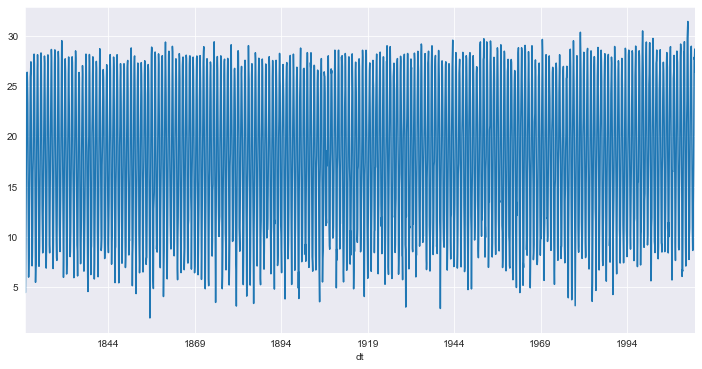

In [57]:
df2['AverageTemperature'].plot()

In [46]:
df2['State'].dtypes =='O'

True

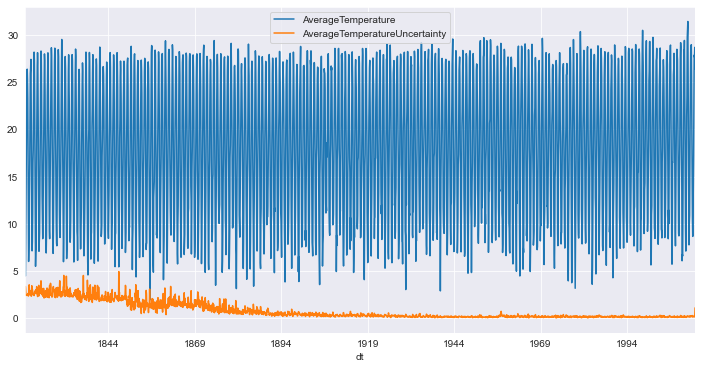

In [58]:
# loop through columns that aren't objects

for col in list(df2):
    if df2[col].dtypes != 'O':
        df2[col].plot(label = col)

plt.legend()
plt.show()

### Takeaways
- Uncertainty early on is pretty high (makes sense from the [docs on kaggle](https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data?select=GlobalLandTemperaturesByState.csv))
- 

In [65]:
df2['AverageTemperatureUncertainty'].describe()

count    2325.000000
mean        0.794785
std         0.893291
min         0.044000
25%         0.180000
50%         0.310000
75%         1.241000
max         4.950000
Name: AverageTemperatureUncertainty, dtype: float64

In [71]:
# lets see where the cutoff is if we throw out uncertainty above 1.24
percentile_75 = df2['AverageTemperatureUncertainty'].quantile(0.75)

df75 = df2[df2['AverageTemperatureUncertainty'] < percentile_75]

In [73]:
df75.shape

(1743, 4)

- Go from 2325 observation to 1743 dropping everything with an uncertainty higher than 1.24, which is still 3/4 of the data 

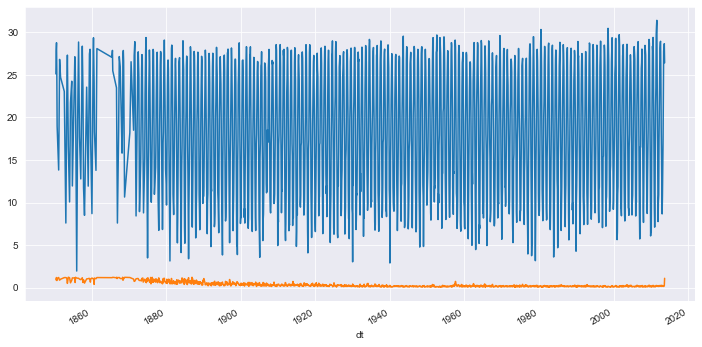

In [76]:
for col in list(df75):
    if df75[col].dtypes != 'O':
        df75[col].plot(label = col)

In [78]:
df75.index.min()

Timestamp('1850-06-01 00:00:00')

### Takeaways
- weird gap around 1868 or so, because of the Civil War?

<AxesSubplot:xlabel='dt'>

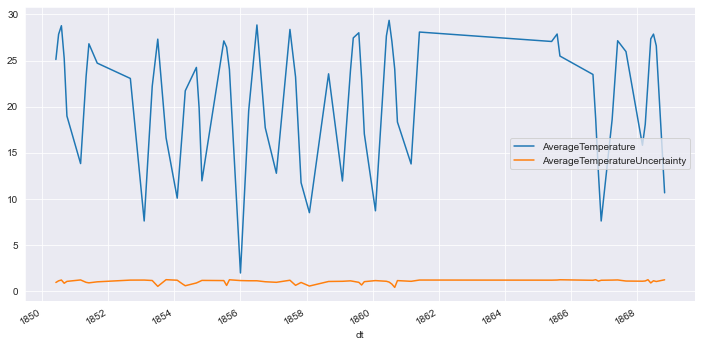

In [96]:
df75.loc[:'1868'].plot(kind='line')

In [95]:
# all dates are unique
df75.reset_index()['dt'].nunique()

1743

In [97]:
# we are missing lots data around the 1860s Will start after that with data
df75.loc['1860':'1868']

,AverageTemperature,AverageTemperatureUncertainty,State,Country
dt,,,,
1860-02-01,8.708,1.140,Texas,United States
1860-06-01,27.667,1.066,Texas,United States
1860-07-01,29.355,0.979,Texas,United States
1860-08-01,27.049,0.759,Texas,United States
1860-09-01,24.067,0.402,Texas,United States
1860-10-01,18.332,1.140,Texas,United States
1861-03-01,13.788,1.062,Texas,United States
1861-06-01,28.087,1.200,Texas,United States
1865-06-01,27.064,1.188,Texas,United States


<AxesSubplot:xlabel='dt'>

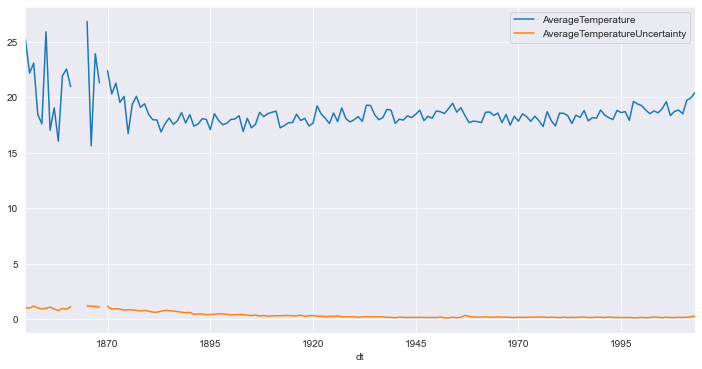

In [110]:
# yearly mean plot let's drop up to where we don't have as many gaps looks to be around 1870 ~ 1875
df75.resample('Y').mean().plot()

In [109]:
# will start with 1875 because we almost have a full year's worth of data with an uncertainty meeting our threshold
df75.loc['1875':].head(12)

,AverageTemperature,AverageTemperatureUncertainty,State,Country
dt,,,,
1875-01-01,3.510,0.826,Texas,United States
1875-02-01,8.910,1.171,Texas,United States
1875-03-01,12.933,0.988,Texas,United States
1875-04-01,16.464,0.992,Texas,United States
1875-05-01,23.072,0.964,Texas,United States
1875-07-01,27.920,0.697,Texas,United States
1875-08-01,26.549,0.646,Texas,United States
1875-09-01,22.672,0.855,Texas,United States
1875-10-01,17.882,0.653,Texas,United States


In [111]:
df4 = df75.loc['1875':]

In [115]:
# dataframe now has 1651 observations
df4.shape

(1651, 4)

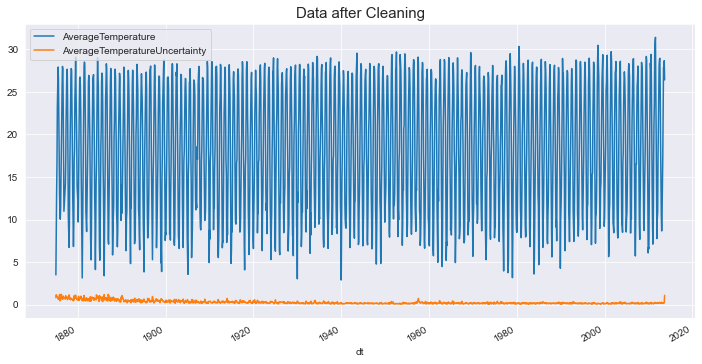

In [120]:
# the data I'm going to use
df4.plot()
plt.title("Data after Cleaning", fontsize = 15)
None

## Split
- use percentage method
- 50-30-20 breakdown

In [126]:
df4.index.max() - df4.index.min() 

Timedelta('50647 days 00:00:00')

In [128]:
years = round(50647/365, 2) 
print(f'There are {years} years in the dataset')

There are 138.76 years in the dataset


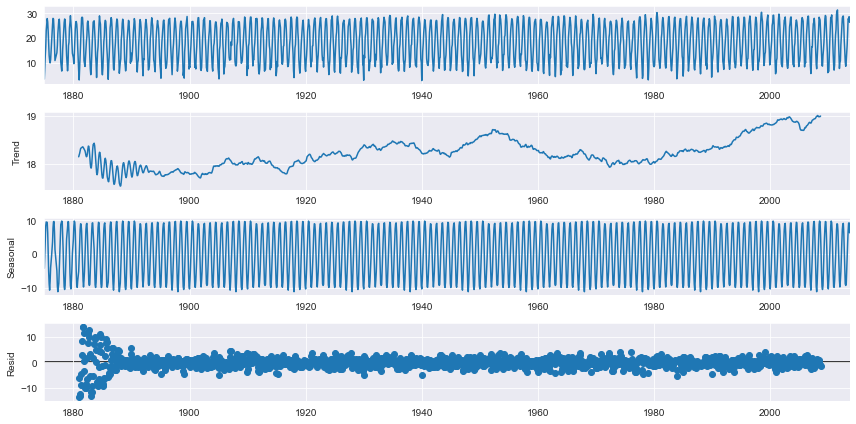

In [198]:
# Are there any seasons? Season decomp for 10 year span. 
# Doesn't seem to be, will go ahead with splitting by percentage
sm.tsa.seasonal_decompose(df5, period = 120).plot()
None

In [211]:
# Split using percentage method
train_size = int(len(df4) * .5)
validate_size = int(len(df4) * .3)
test_size = int(len(df4) - train_size - validate_size)
validate_end_index = train_size + validate_size

# split into train, validation, test
train = df4[: train_size]
validate = df4[train_size : validate_end_index]
test = df4[validate_end_index : ]

In [378]:
# Resplit so single years are in the dataframe
train.index.max(), validate.index.max(), test.index.max()

(Timestamp('1944-11-01 00:00:00'),
 Timestamp('1986-02-01 00:00:00'),
 Timestamp('2013-09-01 00:00:00'))

In [379]:
train.index.min(), validate.index.min(), test.index.min()

(Timestamp('1875-01-01 00:00:00'),
 Timestamp('1944-12-01 00:00:00'),
 Timestamp('1986-03-01 00:00:00'))

In [382]:
# shift them over so single years are all in the correct spot

train = df4.loc[:'1944']
validate = df4.loc['1945': '1985']
test= df4.loc['1986':]

In [212]:
df_list = [train, validate, test]
for df in df_list:
    df.drop(columns= ["State", "Country"], inplace = True )

/opt/homebrew/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


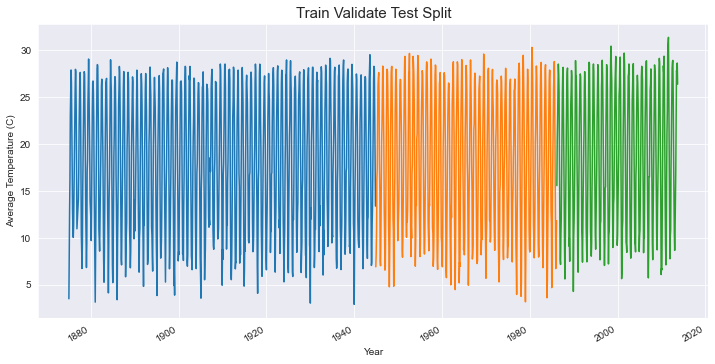

In [216]:
# plot train validate test split
for df in df_list:
    df['AverageTemperature'].plot()
plt.title('Train Validate Test Split')
plt.xlabel('Year')
plt.ylabel('Average Temperature (C)')
plt.show()

In [179]:
# set y as the target here
y = train['AverageTemperature']

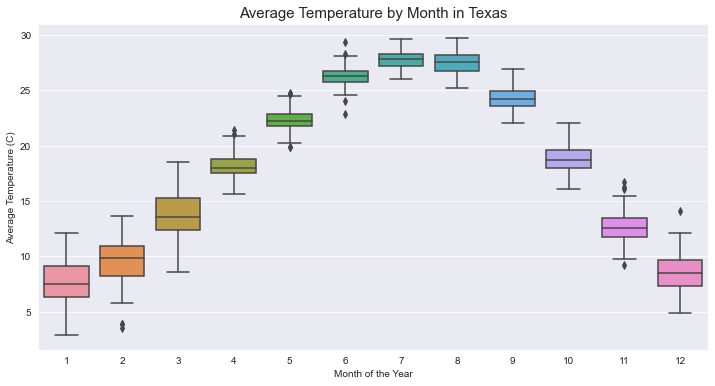

In [205]:
sns.boxplot(data = train, x = train.index.month, y = 'AverageTemperature')
plt.ylabel('Average Temperature (C)')
plt.xlabel('Month of the Year')
plt.title('Average Temperature by Month in Texas')
plt.show()

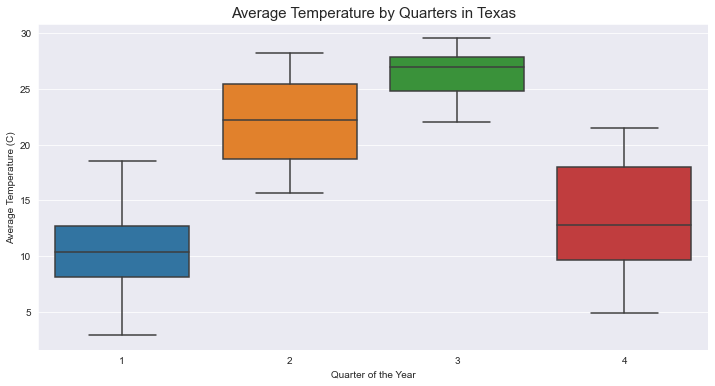

In [287]:
sns.boxplot(data = train, x = train.index.quarter, y = 'AverageTemperature')
plt.ylabel('Average Temperature (C)')
plt.xlabel('Quarter of the Year')
plt.title('Average Temperature by Quarters in Texas')
plt.show()

### Takeaways box plots
- As expected July and August are the hottest months in Texas
- The variability in the temperatures of those months is also small
    - aka. It's hot in the summer in Texas and it's always hot
- Colder months have a greater variability 

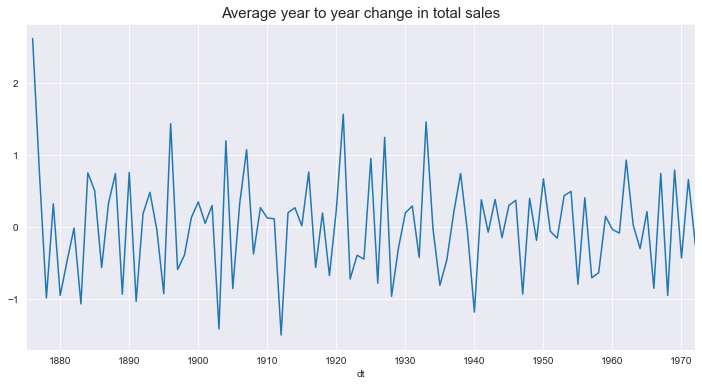

In [202]:
y.resample('Y').mean().diff().plot(title='Average year to year change in total sales')
None

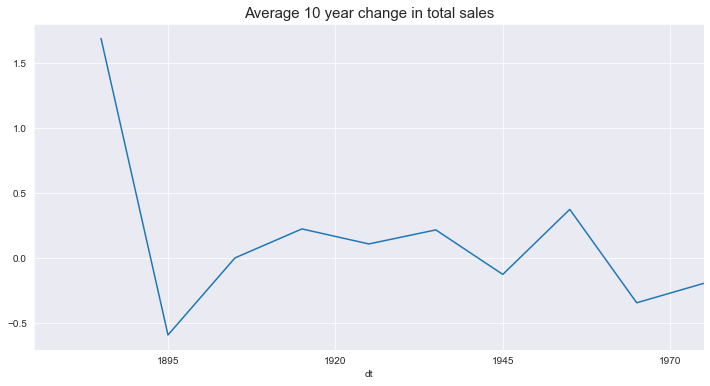

In [203]:
y.resample('10Y').mean().diff().plot(title='Average 10 year change in total sales')
None

### Takeaways from diff plots
- doesn't seem to be much change in average temperatures year to year
- Most change is between 1 and -1
- In 10 years the change is even smaller

Text(0.5, 1.0, 'Year on Year difference')

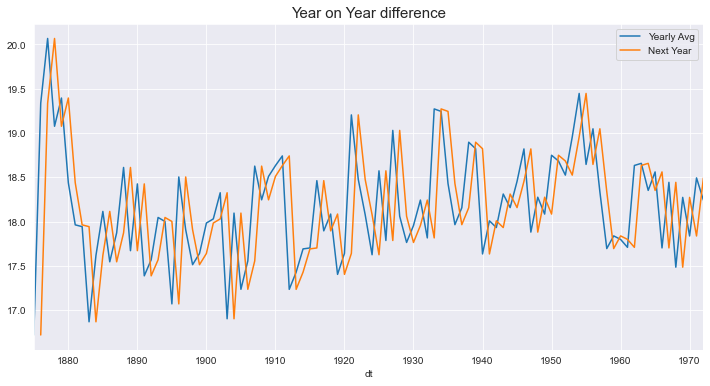

In [229]:
ax = y.resample('Y').mean().plot(label='Yearly Avg')
y.resample('Y').mean().shift(1).plot(label='Next Year', ax=ax)
ax.legend()
plt.title('Year on Year difference')

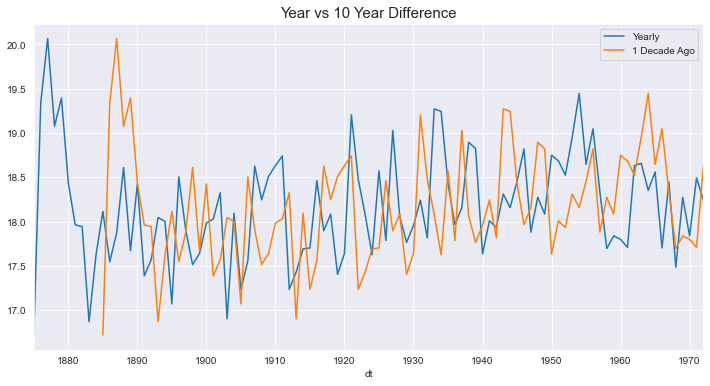

In [227]:
ax = y.resample('Y').mean().plot(label='Yearly')
y.resample('Y').mean().shift(10).plot(label='1 Decade Ago', ax=ax)
ax.legend()
plt.title('Year vs 10 Year Difference')
plt.show()

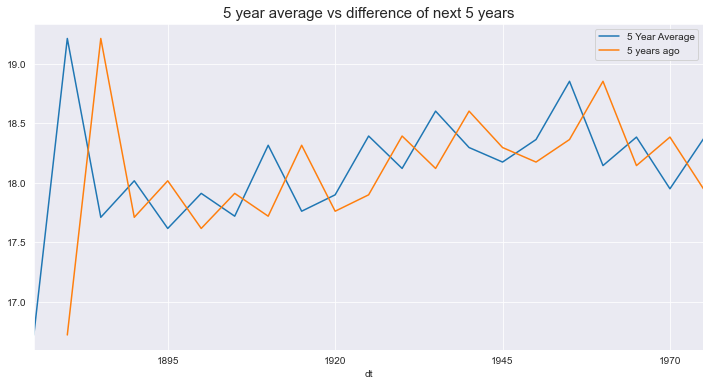

In [234]:
ax = y.resample('5Y').mean().plot(label='5 Year Average')
y.resample('5Y').mean().shift(1).plot(label='5 years ago', ax=ax)
ax.legend()
plt.title('5 year average vs difference of next 5 years')
plt.show()

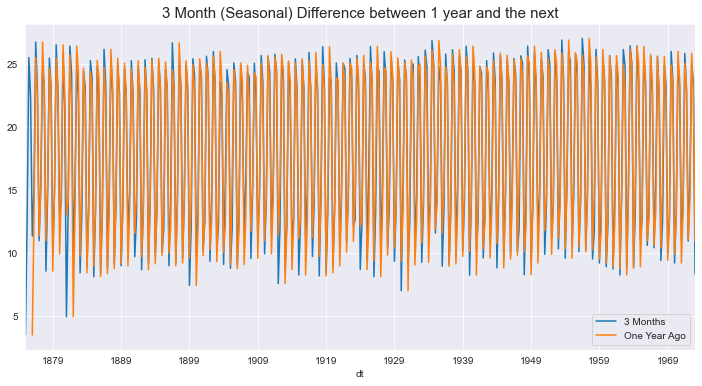

In [237]:
ax = y.resample('3M').mean().plot(label='3 Months')
y.resample('3M').mean().shift(4).plot(label='One Year Ago', ax=ax)
ax.legend()
plt.title('3 Month (Seasonal) Difference between 1 year and the next')
plt.show()

### Takeaways diff plots
- Not much predictive value in using the past year, 10 year or 5 year difference
- Season average temp (3 months), year on year, might be a good predictor. Lots of overlap in this plot

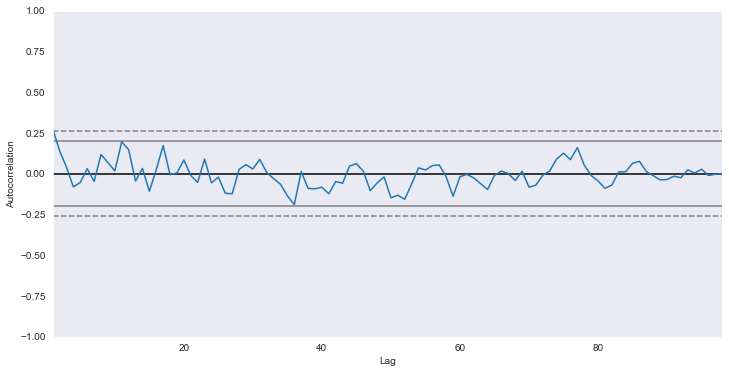

In [241]:
# autocorrelation plot 1 Y resample
pd.plotting.autocorrelation_plot(y.resample('Y').mean())
None

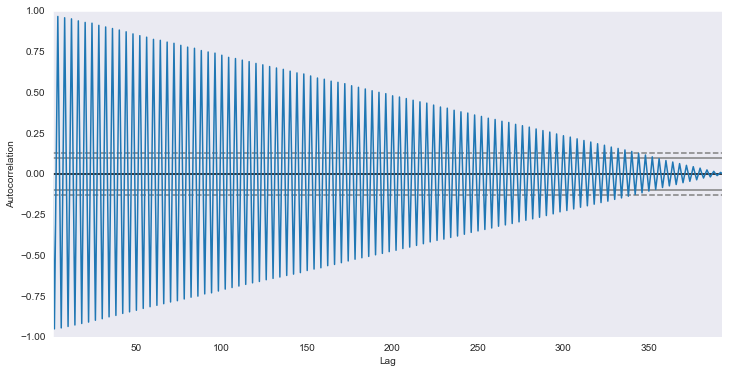

In [242]:
# autocorelation 3 months
pd.plotting.autocorrelation_plot(y.resample('3M').mean())
None

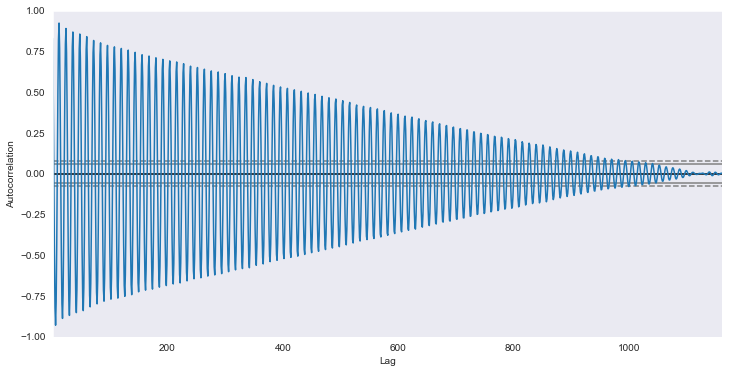

In [243]:
# autocorrelation Monthly
pd.plotting.autocorrelation_plot(y)
None

### Takeaways Autocorrelation plots
- Seasonal trends every 3 months are a good predictor until about 250 seasons in the future
- Seasonal trends every month are a good predictor until about 600 months into the future
- Years are not good predictors

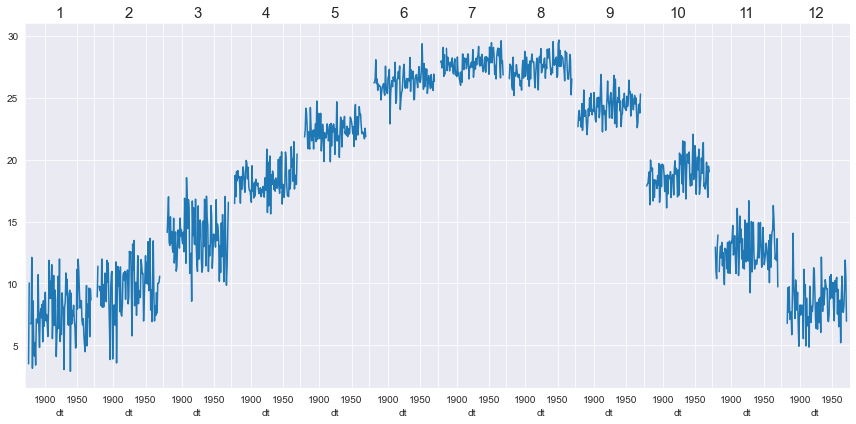

In [244]:
# seasonal subseries plot. Broken down by month
# with more time figure out how to add trend line
fig, axs = plt.subplots(1, 12, sharex=True, sharey=True)
for ax, (month, x) in zip(axs, y.groupby([y.index.year, y.index.month]).mean().unstack().iteritems()):
    x.plot(ax=ax, title=month)
fig.tight_layout()
fig.subplots_adjust(wspace=0)

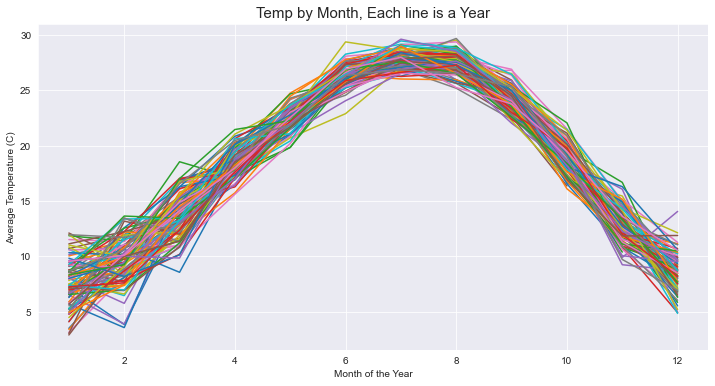

In [249]:
y.groupby([y.index.year, y.index.month]).mean().unstack(0).plot(legend = False)
plt.title('Temp by Month, Each line is a Year')
plt.ylabel('Average Temperature (C)')
plt.xlabel('Month of the Year')
plt.show()

### Takeaways Line Plots
- These two plots further suggest that the temperature per month is a good predictor of the next years temp for that month

------
## Modeling
- Try Simple Average of Temperature
- Try Rolling Average
- Holt Method
- Season Method (based on last month)
    - 3 month and single month


### Set up and Functions

In [289]:
# create dataframe for metrics
metrics_df = pd.DataFrame(columns = ['model_name', 'RMSE'])

In [291]:
# drop the uncertainty column
df_list = [train, validate, test]

for df in df_list:
    df.drop(columns = 'AverageTemperatureUncertainty', inplace = True)

/opt/homebrew/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [315]:
def get_rmse(predictions, actuals):
    '''
    This function takes in predictions and actuals and returns the rmse
    '''
    rmse = mean_squared_error(predictions, actuals, squared = False)
    return rmse

In [297]:
# set up predictions Dataframe 
pred_df = pd.DataFrame(index=train.index)

In [333]:
def append_eval_df(model_type, predictions, actuals, eval_df):
    '''
    this function takes in as arguments the type of model run, and the name of the target variable. 
    It returns the eval_df with the rmse appended to it for that model and target_var. 
    '''
    rmse = get_rmse(predictions, actuals)
    d = {'model_type': [model_type],
        'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

In [332]:
# set up eval Dataframe 
eval_df = pd.DataFrame(columns = ['model_type', 'rmse'])

### Simple Average

In [300]:
# add Simple mean column to Dataframe
pred_df['simple_mean'] = train['AverageTemperature'].mean()

In [301]:
pred_df.head()

,simple_mean
dt,
1875-01-01,18.101999
1875-02-01,18.101999
1875-03-01,18.101999
1875-04-01,18.101999
1875-05-01,18.101999


In [302]:
# assign the predictions to a variable
predictions = train['AverageTemperature'].mean()

In [309]:
# create predictions for validate
validate_pred_df = pd.DataFrame({'simple_mean': [predictions]},
                               index = validate.index)

In [329]:
# RMSE for Validate based on simple Average
simple_mean_rmse = round(get_rmse(validate['AverageTemperature'], validate_pred_df['simple_mean']),2)
simple_mean_rmse

7.49

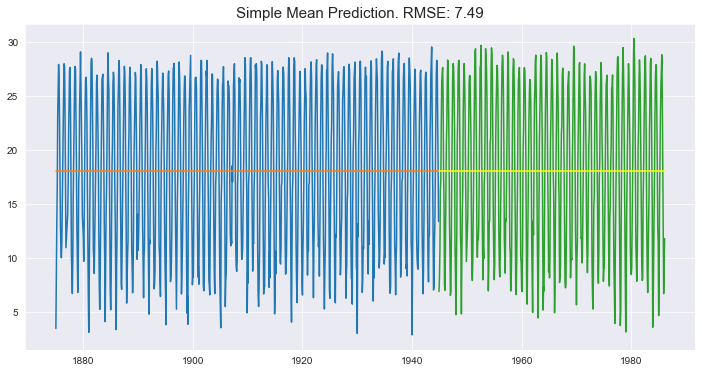

In [330]:
plt.plot(train['AverageTemperature'])
plt.plot(pred_df['simple_mean'])
plt.plot(validate['AverageTemperature'])
plt.plot(validate_pred_df['simple_mean'], color = 'yellow')
plt.title(f'Simple Mean Prediction. RMSE: {simple_mean_rmse}')
plt.show()

In [336]:
eval_df = append_eval_df('simple_mean',validate['AverageTemperature'], validate_pred_df['simple_mean'], eval_df)
eval_df

,model_type,rmse
0,simple_mean,7.48916


### Holt Linear Trend
- Got too complicated and decided not to do this one

### Based on Previous Year

In [391]:
train.loc['1904':'1944'] + train.diff(3).mean()

,AverageTemperature
dt,
1904-01-01,6.742761
1904-02-01,11.762761
1904-03-01,16.903761
1904-04-01,18.041761
1904-05-01,21.788761
...,...
1944-08-01,28.083761
1944-09-01,23.778761
1944-10-01,18.848761


In [419]:
validate_predictions = train.loc['1904':'1944'] + train.diff(3).mean()

In [421]:
v_pred = validate_predictions.values.flatten()

In [422]:
# create predictions for validate
validate_pred_df = pd.DataFrame({'last_year_avg':v_pred},
                               index = validate.index)

In [423]:
validate_pred_df

,last_year_avg
dt,
1945-01-01,6.742761
1945-02-01,11.762761
1945-03-01,16.903761
1945-04-01,18.041761
1945-05-01,21.788761
...,...
1985-08-01,28.083761
1985-09-01,23.778761
1985-10-01,18.848761


In [434]:
prev_year_rmse = round(get_rmse(validate['AverageTemperature'], validate_pred_df['last_year_avg']),2)
prev_year_rmse

2.17

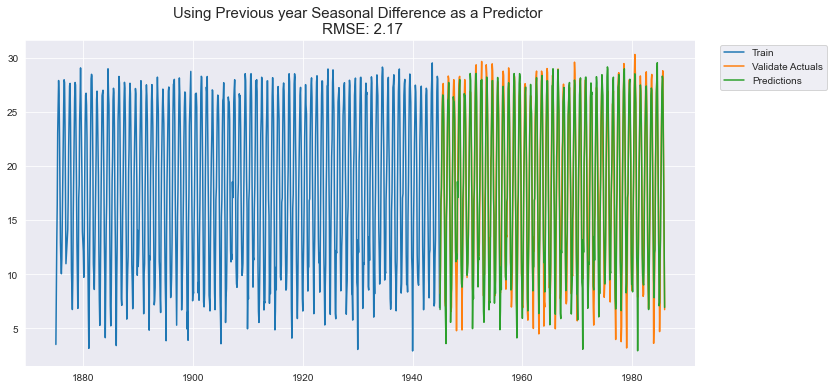

In [436]:
plt.plot(train, label = 'Train')
plt.plot(validate['AverageTemperature'], label = 'Validate Actuals')
plt.plot(validate_pred_df['last_year_avg'], label = 'Predictions')
plt.title(f'Using Previous year Seasonal Difference as a Predictor \n RMSE: {prev_year_rmse}')
plt.legend(bbox_to_anchor = (1.03, 1))
plt.show()